In [1]:
import torch
import torchvision
# import pycuda.driver as cuda
# cuda.init()
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import scipy.io
import os
import gc

In [2]:
#DIlated Residual Block, refer photo
class DRB(nn.Module):
    def __init__(self,inchannels,negative_slope=0.01):
        super(DRB, self).__init__()
        
        self.conv111=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv111_bn=nn.BatchNorm1d(1)
        self.conv112=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv112_bn=nn.BatchNorm1d(1)
        self.conv113=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv113_bn=nn.BatchNorm1d(1)
        self.conv114=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv114_bn=nn.BatchNorm1d(1)
        
        self.relu1=nn.LeakyReLU(negative_slope,0)
        self.conv131=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=2,dilation=2)
        self.conv131_bn=nn.BatchNorm1d(1)
        self.relu2=nn.LeakyReLU(negative_slope,0)
        self.conv132=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=4,dilation=4)
        self.conv132_bn=nn.BatchNorm1d(1)
        self.relu3=nn.LeakyReLU(negative_slope,0)
        self.conv133=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=8,dilation=8)
        self.conv133_bn=nn.BatchNorm1d(1)
        
        self.conv11p=nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1,stride=1)
            

    def forward(self, x):
        x1=self.conv111_bn(self.conv111(x))
        
        x2=self.relu1(self.conv112_bn(self.conv112(x)))
        x2=self.conv131_bn(self.conv131(x2))
        
        x3=self.relu1(self.conv113_bn(self.conv113(x)))
        x3=self.conv132_bn(self.conv132(x3))
        
        x4=self.relu1(self.conv114_bn(self.conv114(x)))
        x4=self.conv133_bn(self.conv133(x4))
        
        x5=torch.cat((x1,x2,x3,x4),1)
        y=self.conv11p(x5)
        
        return x+y


In [3]:
#whole neural network , refer photo
class Net(nn.Module):
    def __init__(self,first_layer_filters=32,negative_slope=0.01):
        super(Net, self).__init__()
        
        self.in_channels1=1
        self.out_channels1=first_layer_filters
        self.Drb11=DRB(self.in_channels1)
        self.conv11=nn.Conv1d(in_channels=self.in_channels1,out_channels=self.out_channels1,kernel_size=4,stride=2,padding=1)
        self.conv11_bn=nn.BatchNorm1d(self.out_channels1)  
        self.relu11=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels2=self.out_channels1
        self.out_channels2=min(self.out_channels1*2,512)
        self.Drb12=DRB(self.in_channels2)
        self.conv12=nn.Conv1d(in_channels=self.in_channels2,out_channels=self.out_channels2,kernel_size=4,stride=2,padding=1)
        self.conv12_bn=nn.BatchNorm1d(self.out_channels2)
        self.relu12=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels3=self.out_channels2
        self.out_channels3=min(self.out_channels2*2,512)
        self.Drb13=DRB(self.in_channels3)
        self.conv13=nn.Conv1d(in_channels=self.in_channels3,out_channels=self.out_channels3,kernel_size=4,stride=2,padding=1)
        self.conv13_bn=nn.BatchNorm1d(self.out_channels3)
        self.relu13=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels4=self.out_channels3
        self.out_channels4=min(self.out_channels3*2,512)
        self.Drb14=DRB(self.in_channels4)
        self.conv14=nn.Conv1d(in_channels=self.in_channels4,out_channels=self.out_channels4,kernel_size=4,stride=2,padding=1)
        self.conv14_bn=nn.BatchNorm1d(self.out_channels4)
        self.relu14=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels5=self.out_channels4
        self.out_channels5=min(self.out_channels4*2,512)
        self.Drb15=DRB(self.in_channels5)
        self.conv15=nn.Conv1d(in_channels=self.in_channels5,out_channels=self.out_channels5,kernel_size=4,stride=2,padding=1)
        self.conv15_bn=nn.BatchNorm1d(self.out_channels5)
        self.relu15=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels6=self.out_channels5
        self.out_channels6=min(self.out_channels5*2,512)
        self.Drb16=DRB(self.in_channels6)
        self.conv16=nn.Conv1d(in_channels=self.in_channels6,out_channels=self.out_channels6,kernel_size=4,stride=2,padding=1)
        self.conv16_bn=nn.BatchNorm1d(self.out_channels6)
        self.relu16=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels7=self.out_channels6
        self.out_channels7=min(self.out_channels6*2,512)
        self.Drb17=DRB(self.in_channels7)
        self.conv17=nn.Conv1d(in_channels=self.in_channels7,out_channels=self.out_channels7,kernel_size=4,stride=2,padding=1)
        self.conv17_bn=nn.BatchNorm1d(self.out_channels7)
        self.relu17=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels8=self.out_channels7
        self.Drb21=DRB(self.in_channels8)
        self.deconv21=nn.ConvTranspose1d(in_channels=self.in_channels8,out_channels=self.in_channels7,kernel_size=4,stride=2,padding=1)
        self.conv21_bn=nn.BatchNorm1d(self.in_channels7)
        self.relu21=nn.LeakyReLU(negative_slope,0)
        
        self.Drb22=DRB(self.in_channels7*2)
        self.deconv22=nn.ConvTranspose1d(in_channels=self.in_channels7*2,out_channels=self.in_channels6,kernel_size=4,stride=2,padding=1)
        self.conv22_bn=nn.BatchNorm1d(self.in_channels6)
        self.relu22=nn.LeakyReLU(negative_slope,0)
        
        self.Drb23=DRB(self.in_channels6*2)
        self.deconv23=nn.ConvTranspose1d(in_channels=self.in_channels6*2,out_channels=self.in_channels5,kernel_size=4,stride=2,padding=1)
        self.conv23_bn=nn.BatchNorm1d(self.in_channels5)
        self.relu23=nn.LeakyReLU(negative_slope,0)
        
        self.Drb24=DRB(self.in_channels5*2)
        self.deconv24=nn.ConvTranspose1d(in_channels=self.in_channels5*2,out_channels=self.in_channels4,kernel_size=4,stride=2,padding=1)
        self.conv24_bn=nn.BatchNorm1d(self.in_channels4)
        self.relu24=nn.LeakyReLU(negative_slope,0)
        
        self.Drb25=DRB(self.in_channels4*2)
        self.deconv25=nn.ConvTranspose1d(in_channels=self.in_channels4*2,out_channels=self.in_channels3,kernel_size=4,stride=2,padding=1)
        self.conv25_bn=nn.BatchNorm1d(self.in_channels3)
        self.relu25=nn.LeakyReLU(negative_slope,0)
        
        self.Drb26=DRB(self.in_channels3*2)
        self.deconv26=nn.ConvTranspose1d(in_channels=self.in_channels3*2,out_channels=self.in_channels2,kernel_size=4,stride=2,padding=1)
        self.conv26_bn=nn.BatchNorm1d(self.in_channels2)
        self.relu26=nn.LeakyReLU(negative_slope,0)
        
        self.Drb27=DRB(self.in_channels2*2)
        self.deconv27=nn.ConvTranspose1d(in_channels=self.in_channels2*2,out_channels=self.in_channels1,kernel_size=4,stride=2,padding=1)
        self.conv27_bn=nn.BatchNorm1d(self.in_channels1)
        self.relu27=nn.LeakyReLU(negative_slope,0)
        
        self.Drb28=DRB(self.in_channels1*2)
        self.conv28=nn.Conv1d(in_channels=self.in_channels1*2,out_channels=self.in_channels1,kernel_size=1,stride=1,padding=0)
        

    def forward(self, x):
        
        x1=self.relu11(self.conv11_bn(self.conv11(self.Drb11(x))))
           
        x2=self.relu12(self.conv12_bn(self.conv12(self.Drb12(x1))))
        
        x3=self.relu13(self.conv13_bn(self.conv13(self.Drb13(x2))))
        
        x4=self.relu14(self.conv14_bn(self.conv14(self.Drb14(x3))))
        
        x5=self.relu15(self.conv15_bn(self.conv15(self.Drb15(x4))))
        
        x6=self.relu16(self.conv16_bn(self.conv16(self.Drb16(x5))))
        
        x7=self.relu17(self.conv17_bn(self.conv17(self.Drb17(x6))))
        
        x8=self.relu21(self.conv21_bn(self.deconv21(self.Drb21(x7))))
        
        x8=torch.cat((x8,x6),1)
        x9=self.relu22(self.conv22_bn(self.deconv22(self.Drb22(x8))))
        
        x9=torch.cat((x9,x5),1)
        x10=self.relu23(self.conv23_bn(self.deconv23(self.Drb23(x9)))) 
        
        x10=torch.cat((x10,x4),1)
        x11=self.relu24(self.conv24_bn(self.deconv24(self.Drb24(x10)))) 
        
        x11=torch.cat((x11,x3),1)
        x12=self.relu25(self.conv25_bn(self.deconv25(self.Drb25(x11)))) 
        
        x12=torch.cat((x12,x2),1)
        x13=self.relu26(self.conv26_bn(self.deconv26(self.Drb26(x12)))) 
        
        x13=torch.cat((x13,x1),1)
        x14=self.relu27(self.conv27_bn(self.deconv27(self.Drb27(x13)))) 
        
        x14=torch.cat((x14,x),1)
        x15=self.conv28(self.Drb28(x14))
        
        return x15

In [4]:
net=Net().double().cuda()

In [5]:
x_data=np.empty((42,122881))
y_data=np.empty((42,122881))

In [6]:
path='train_data/x_train/'
j=0
for file in sorted(os.listdir('train_data/x_train')):
    x=scipy.io.loadmat(path+file)
    print(file)
    x=x['zx'].astype('double')
    x=x.reshape(-1)
    x_data[j]=x
    j+=1

x_train1.mat
x_train10.mat
x_train11.mat
x_train12.mat
x_train13.mat
x_train14.mat
x_train15.mat
x_train16.mat
x_train17.mat
x_train18.mat
x_train19.mat
x_train2.mat
x_train20.mat
x_train21.mat
x_train22.mat
x_train23.mat
x_train24.mat
x_train25.mat
x_train26.mat
x_train27.mat
x_train28.mat
x_train29.mat
x_train3.mat
x_train30.mat
x_train31.mat
x_train32.mat
x_train33.mat
x_train34.mat
x_train35.mat
x_train36.mat
x_train37.mat
x_train38.mat
x_train39.mat
x_train4.mat
x_train40.mat
x_train41.mat
x_train42.mat
x_train5.mat
x_train6.mat
x_train7.mat
x_train8.mat
x_train9.mat


In [7]:
path='train_data/y_train/'
j=0
for file in sorted(os.listdir('train_data/y_train')):
    x=scipy.io.loadmat(path+file)
    print(file)
    x=x['zy'].astype('double')
    x=x.reshape(-1)
    y_data[j]=x
    j+=1

y_train1.mat
y_train10.mat
y_train11.mat
y_train12.mat
y_train13.mat
y_train14.mat
y_train15.mat
y_train16.mat
y_train17.mat
y_train18.mat
y_train19.mat
y_train2.mat
y_train20.mat
y_train21.mat
y_train22.mat
y_train23.mat
y_train24.mat
y_train25.mat
y_train26.mat
y_train27.mat
y_train28.mat
y_train29.mat
y_train3.mat
y_train30.mat
y_train31.mat
y_train32.mat
y_train33.mat
y_train34.mat
y_train35.mat
y_train36.mat
y_train37.mat
y_train38.mat
y_train39.mat
y_train4.mat
y_train40.mat
y_train41.mat
y_train42.mat
y_train5.mat
y_train6.mat
y_train7.mat
y_train8.mat
y_train9.mat


In [8]:
for i in range(42):
    x_data[i]=(x_data[i]-min(x_data[i]))/(max(x_data[i])-min(x_data[i]))
    y_data[i]=(y_data[i]-min(y_data[i]))/(max(y_data[i])-min(y_data[i]))

In [9]:
x_data_div=np.empty((2520,1,2048),dtype='double')
y_data_div=np.empty((2520,1,2048),dtype='double')

In [10]:
for j in range(42):
    for i in range(60):
        x_data_div[i+j*60]=x_data[j][i*2048:(i+1)*2048]
        y_data_div[i+j*60]=y_data[j][i*2048:(i+1)*2048]

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x_data_div,y_data_div,test_size=0.2,shuffle=True)

In [12]:
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)

In [5]:
x_train=np.load("x_train.npy")
x_test=np.load("x_test.npy")
y_train=np.load("y_train.npy")
y_test=np.load("y_test.npy")

In [19]:
x_train1=torch.from_numpy(x_train).double().cuda()
y_train1=torch.from_numpy(y_train).double().cuda()

In [28]:
criterion=nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.7)

In [29]:
for epoch in range(10):
    for i in range(8):
        optimizer.zero_grad()
        outputs = net(x_train1[i*256:min(2016,(i+1)*256)])
        loss = criterion(outputs, y_train1[i*256:min(2016,(i+1)*256)])
        print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(epoch,i)
    print(torch.cuda.memory_allocated())
#     print(loss)
print('Finished Training')

tensor(0.0766, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 0
tensor(0.0764, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 1
tensor(0.0765, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 2
tensor(0.0770, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 3
tensor(0.0778, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 4
tensor(0.0766, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 5
tensor(0.0758, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 6
tensor(0.0753, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
0 7
331702272
tensor(0.0764, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
1 0
tensor(0.0763, device='cuda:0', dtype=torch.float64,
       grad_fn=<SmoothL1LossBackward>)
1 1
tensor(0.0763, device='cuda:0'

KeyboardInterrupt: 

In [18]:
x_test=np.load("x_test.npy")
y_test=np.load("y_test.npy")

In [10]:
x_test=x_test.reshape((126,1,8192))
y_test=y_test.reshape((126,1,8192))

In [8]:
x_test=torch.from_numpy(x_test).double().cuda()
y_test=torch.from_numpy(y_test).double().cuda()

In [12]:
with torch.no_grad():
    x_ans=net(x_test)

In [14]:
x_ans_scale=np.empty((504,1,2048))
y_ans_scale=np.empty((504,1,2048))

In [15]:
x_ans_t=x_ans.cpu().numpy()
y_ans_t=y_test.cpu().numpy()

In [21]:
min(x_ans_t[0][0])

0.13106257

In [22]:
for i in range(504):
    x_ans_scale[i][0]=(x_ans_t[i][0]-min(x_ans_t[i][0]))/(max(x_ans_t[i][0])-min(x_ans_t[i][0]))
    x_ans_scale[i][0]= x_ans_scale[i][0]*((max(x_ans_scale[i][0])-min(x_ans_scale[i][0])))+min(x_ans_scale[i][0])
    y_ans_scale[i][0]=(y_ans_t[i][0]-min(y_ans_t[i][0]))/(max(y_ans_t[i][0])-min(y_ans_t[i][0]))
    y_ans_scale[i][0]= y_ans_scale[i][0]*((max(y_ans_scale[i][0])-min(y_ans_scale[i][0])))+min(y_ans_scale[i][0])

In [25]:
x_ans_t.shape

(252, 1, 4096)

In [12]:
criterion2=nn.MSELoss(reduction='mean')

In [13]:
l1error=criterion2(x_ans,y_test)
l1error

tensor(0.0719, device='cuda:0', dtype=torch.float64)

In [36]:
xphy=scipy.io.loadmat("x1.mat")['y1']
yphy=scipy.io.loadmat("y1.mat")['x1']

In [37]:
xphy=(xphy-np.mean(xphy))/np.std(xphy)

In [33]:
xphy=xphy.reshape(1,-1)
yphy=yphy.reshape(1,-1)

In [38]:
x_test_new =np.empty((480,1,2048))
y_test_new=np.empty((480,1,2048))

In [40]:
for i in range(60):
    x_test_new[i]=xphy[i*2048:(i+1)*2048].reshape(1,-1)
    y_test_new[i]=yphy[i*2048:(i+1)*2048].reshape(1,-1)

In [43]:
xphyt=torch.from_numpy(x_test_new).float().cuda()
yphyt=torch.from_numpy(y_test_new).float().cuda()

In [44]:
with torch.no_grad():
    xphyans=net(xphyt)

In [46]:
x_ans_scale=np.empty((480,1,2048))
x_ans_t=xphyans.cpu().numpy()

In [48]:
for i in range(480):
    x_ans_scale[i][0]=(x_ans_t[i][0]-min(x_ans_t[i][0]))/(max(x_ans_t[i][0])-min(x_ans_t[i][0]))
    x_ans_scale[i][0]= x_ans_scale[i][0]*((max(x_ans_scale[i][0])-min(x_ans_scale[i][0])))+min(x_ans_scale[i][0])

array([0.35410009, 0.40280851, 0.35939134, ..., 0.80900415, 0.8160364 ,
       0.82149495])

In [18]:
l1error=criterion2(torch.from_numpy(x_ans_t).float(),torch.from_numpy(y_ans_t).float())
l1error

tensor(2.4930)

In [15]:
x_test

array([[[-3.83560285, -3.90245831, -3.9656548 , ...,  5.03264461,
          4.84113817,  4.6187083 ]],

       [[ 4.65978084,  4.62267879,  4.57791927, ..., -2.42012207,
         -2.4205834 , -2.41949229]],

       [[-0.40027747, -0.41083491, -0.40870417, ..., -0.23847624,
         -0.24661941, -0.25105253]],

       ...,

       [[-1.44205682, -1.62678431, -1.81616312, ...,  6.22498938,
          6.40071001,  6.51120325]],

       [[-7.78860111, -7.84641005, -7.91302679, ..., -1.3209972 ,
         -1.34691749, -1.40038142]],

       [[-0.3701468 , -0.36977476, -0.37020333, ..., -1.19590025,
         -1.18306413, -1.17249403]]])

array([[-3.83560285, -3.90245831, -3.9656548 , ..., -2.42012207,
        -2.4205834 , -2.41949229]])

In [6]:
index=np.arange(1,2049,1)

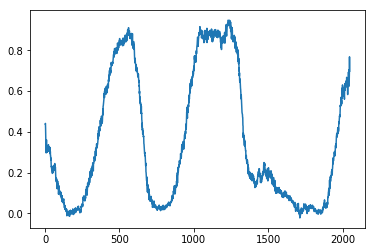

In [14]:
plt.plot(index,x_ans.cpu().numpy()[0][0])

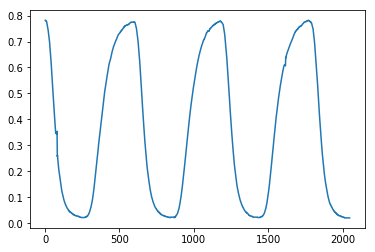

In [15]:
plt.plot(index,y_test.cpu().numpy()[0][0])

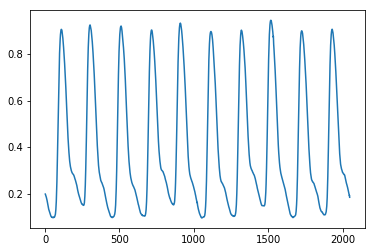

In [16]:
plt.plot(index,x_test.cpu().numpy()[0][0])

In [76]:
from pyampd.ampd import find_peaks

In [135]:
find_peaks(x_ans_t[0][0],650)

array([ 523, 1250, 3155, 5187, 6646, 7521])

In [117]:
find_peaks(y_ans_t[0][0],300).size

7

In [53]:
brpx=np.empty((126))
brpy=np.empty((126))

In [54]:
for i in range(126):
    brpx[i]=scipy.signal.find_peaks(x_ans_t[i][0],distance=600)[0].size
    brpy[i]=scipy.signal.find_peaks(y_ans_t[i][0],distance=600)[0].size

In [61]:
sum(abs(brpx-brpy))/126



0.8253968253968254

In [18]:
brpy

NameError: name 'brpy' is not defined

In [16]:
torch.save(net.state_dict(),"mynet.pt")

In [23]:
net.load_state_dict(torch.load("mynet.pt"))
net.eval()

Net(
  (Drb11): DRB(
    (conv111): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv111_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv112): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv112_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv113): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv113_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv114): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv114_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (conv131): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (conv131_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (conv132): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(4,), dilation=